In [876]:
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import zoom, binary_dilation

from PIL import Image
from sympy.stats.sampling.sample_numpy import numpy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [877]:
class ClampBounds:
    def __init__(self, min, max):
        self.min = min
        self.max = max

In [878]:
class ClampConfiguration:
    def __init__(self, color_bounds: ClampBounds, water_bounds: ClampBounds, surface_water_bounds: ClampBounds, wet_soil_bounds: ClampBounds, soil_bounds: ClampBounds):
        self.color_bounds = color_bounds
        self.water_bounds = water_bounds
        self.surface_water_bounds = surface_water_bounds
        self.wet_soil_bounds = wet_soil_bounds
        self.soil_bounds = soil_bounds

In [879]:
class Band:
    def __init__(self, band_index, data, clamping_configuration: ClampConfiguration):
        self.band_index = band_index
        self.clamping_configuration = clamping_configuration
        
        self.band_data_raw = data
        
        # avg_brightness = np.mean(data)
        # normalized_data = data - avg_brightness
        self.band_data = self.band_data_raw

        self.band_data_clamped = self.get_clamped()
        
    def get_original_band_bounds(self):
        return self.band_data.min(), self.band_data.max()
        
    def get_clamped(self):
        return self.stretch_to_min_max(self.clamping_configuration.color_bounds.min, self.clamping_configuration.color_bounds.max)
    
    @staticmethod
    def normalize(band_data):
        band_min, band_max = (band_data.min(), band_data.max())
        return (band_data - band_min) / (band_max - band_min)
    
    @staticmethod
    def brighten(band_data):
        alpha = 0.13
        beta = 0
        return np.clip(alpha * band_data + beta, 0, 255)
    
    @staticmethod
    def get_normalized_layer(data, masked: bool):
        normalized = Band.normalize(data)
        if masked:
            return np.ma.masked_where(normalized == 0, normalized)
        else:
            return normalized
        
    def get_water_mask(self, sensitivity, binary: bool):
        water_layer_mask = self.get_water_layer(True)
        surface_water_layer_mask =  np.where(self.get_surface_water_layer(True) == 1, self.get_surface_water_layer(True) * sensitivity, 0)
        wet_soil_layer_mask = np.where(self.get_wet_soil_layer(True) == 1, self.get_wet_soil_layer(True) * sensitivity, 0)
        soil_mask = self.get_soil_layer(True)
        
        safezone_size = max(3, round(sensitivity * 10))
    
        buffer_zone = binary_dilation(water_layer_mask, structure=np.ones((safezone_size, safezone_size)))
    
        surface_water_layer_mask = surface_water_layer_mask * buffer_zone
        wet_soil_layer_mask = wet_soil_layer_mask * buffer_zone
        soil_mask = np.where(soil_mask == 1, soil_mask * (max(0.1, sensitivity) / 2), 0) * (buffer_zone * -1)
    
        mask = water_layer_mask + surface_water_layer_mask + wet_soil_layer_mask - soil_mask
    
        normalized_mask = self.normalize(mask)
        if binary:
            return self.stretch_and_clip_binary_data(normalized_mask, 0.5, normalized_mask.max())
        return mask
    
    def get_all_layers(self, binary: bool):
        return {
            'Water': self.get_water_layer(binary), 
            'Surface water': self.get_surface_water_layer(binary),
            'Wet soil': self.get_wet_soil_layer(binary), 
            'Soil': self.get_soil_layer(binary),
        }
    
    def stretch_and_clip_binary(self, lower_bound, upper_bound):
        binary_band = np.where((self.band_data_clamped >= lower_bound) & (self.band_data_clamped <= upper_bound), 1, 0)
        return binary_band
    
    def stretch_and_clip_binary_data(self, data, lower_bound, upper_bound):
        binary_band = np.where((data >= lower_bound) & (data <= upper_bound), 1, 0)
        return binary_band
    
    def get_as_compact_binary(self, data):
        binary_band = np.where(data == 1, True, False)
        return binary_band
    
    def stretch_and_clip(self, min_val, max_val):
        band_min, band_max = self.get_original_band_bounds()
        stretched_band = (self.band_data - band_min) / (band_max - band_min) * (max_val - min_val) + min_val
        return np.clip(stretched_band, min_val, max_val)
    
    def stretch_clamped_to_min_max(self, min_val, max_val):
        band_min, band_max = min_val, max_val
        stretched_band = (self.band_data_clamped - band_min) / (band_max - band_min) * (max_val - min_val) + min_val
        return np.clip(stretched_band, min_val, max_val)
    
    def stretch_to_min_max(self, min_val, max_val):
        band_min, band_max = min_val, max_val
        stretched_band = (self.band_data - band_min) / (band_max - band_min) * (max_val - min_val) + min_val
        return np.clip(stretched_band, min_val, max_val)
    
    def get_normalized(self):
        band_pixels = Band.brighten(self.band_data_clamped)
        normalized = Band.normalize(band_pixels)
        return normalized
        
    def get_water_layer(self, binary: bool):
        min_val = self.clamping_configuration.water_bounds.min
        max_val = self.clamping_configuration.water_bounds.max
        if binary:
            return self.stretch_and_clip_binary(min_val, max_val)
        return self.stretch_clamped_to_min_max(min_val, max_val)
        
    def get_surface_water_layer(self, binary: bool):
        min_val = self.clamping_configuration.surface_water_bounds.min
        max_val = self.clamping_configuration.surface_water_bounds.max
        if binary:
            return self.stretch_and_clip_binary(min_val, max_val)
        return self.stretch_clamped_to_min_max(min_val, max_val)
        
    def get_wet_soil_layer(self, binary: bool):
        min_val = self.clamping_configuration.wet_soil_bounds.min
        max_val = self.clamping_configuration.wet_soil_bounds.max
        if binary:
            return self.stretch_and_clip_binary(min_val, max_val)
        return self.stretch_clamped_to_min_max(min_val, max_val)
        
    def get_soil_layer(self, binary: bool):
        min_val = self.clamping_configuration.soil_bounds.min
        max_val = self.clamping_configuration.soil_bounds.max
        if binary:
            return self.stretch_and_clip_binary(min_val, max_val)
        return self.stretch_clamped_to_min_max(min_val, max_val)

In [1000]:
class MultibandImage:
    def __init__(self, image_path, clamping_configurations):
        self.bands = []
        self.image_path = image_path
        
        try:
            with rasterio.open(image_path) as fin:
                for index, configuration in clamping_configurations.items():
                    band_pixels = fin.read(index)
                    self.bands.append(Band(index, band_pixels, configuration))
        except:
            print(image_path + '- failed to open')
            return
            
                
    def get_water_mask(self, sensitivity, binary: bool):
        if len(self.bands) == 0:
            return None
        band7 = self.get_band(7)
        band8 = self.get_band(8)
        band9 = self.get_band(9)
        band10 = self.get_band(10)
        
        band7_water_mask = band7.get_water_mask(sensitivity, binary)
        band8_water_mask = band8.get_water_mask(sensitivity, binary)
        band9_water_mask = band9.get_water_mask(sensitivity, binary)
        band10_water_mask = band10.get_water_mask(sensitivity / 2, binary)
        
        # resize masks to match biggest res
        zoom_factor_band8 = np.array(band7_water_mask.shape) / np.array(band8_water_mask.shape)
        zoom_factor_band9 = np.array(band7_water_mask.shape) / np.array(band9_water_mask.shape)
        zoom_factor_band10 = np.array(band7_water_mask.shape) / np.array(band10_water_mask.shape)
        
        band8_water_mask = zoom(band8_water_mask, zoom=zoom_factor_band8, order=1)
        band9_water_mask = zoom(band9_water_mask, zoom=zoom_factor_band9, order=1)
        band10_water_mask = zoom(band10_water_mask, zoom=zoom_factor_band10, order=1)
        
        if binary:
            band8_water_mask = np.array(band8_water_mask, dtype=bool)
            band9_water_mask = np.array(band9_water_mask, dtype=bool)
            band10_water_mask = np.array(band10_water_mask, dtype=bool)
            mask = band7_water_mask | band8_water_mask | (band9_water_mask & band10_water_mask)
            return mask
        else:
            return Band.normalize(band9_water_mask + band7_water_mask + band9_water_mask + band8_water_mask + band10_water_mask)
        
        
    def get_band(self, index):
        for band in self.bands:
            if index == band.band_index:
                return band
        return None

# Loading data

In [1001]:
def get_data_list(img_path):
    full_paths = []
    for root, _, filenames in os.walk(img_path):
        for filename in filenames:
            full_path = os.path.join(root, filename)
            full_paths.append(full_path)

    df = pd.DataFrame({'file_path': full_paths}).sort_values('file_path').reset_index(drop=True)
    df = df['file_path'].values

    return df

### Folder to load images from

In [1002]:
data_list = get_data_list(os.path.curdir + '/Data/test/test_scoltech/images/')

### Configuration for layer slicing

In [894]:
band7_clamp_config = ClampConfiguration(ClampBounds(0,1600), ClampBounds(0,400), ClampBounds(400,600),ClampBounds(600,880), ClampBounds(880,1600))
band8_clamp_config = ClampConfiguration(ClampBounds(0,1600), ClampBounds(0,400), ClampBounds(400,600),ClampBounds(600,880), ClampBounds(880,1600))
band9_clamp_config = ClampConfiguration(ClampBounds(0,1600), ClampBounds(0,640), ClampBounds(640,1120),ClampBounds(1120,1280), ClampBounds(1280,1600))
band10_clamp_config = ClampConfiguration(ClampBounds(0,1600), ClampBounds(0,250), ClampBounds(250,720),ClampBounds(720,960), ClampBounds(960,1600))

In [895]:
clamping_configurations = {
    7: band7_clamp_config,
    8: band8_clamp_config,
    9: band9_clamp_config,
    10: band10_clamp_config
}

# Define images

In [1003]:
images = [MultibandImage(path, clamping_configurations) for path in data_list]

# Visualization of per-band mask generation pipeline

In [928]:
def plot_data_band_display_by_index(image: MultibandImage, band_index: int, binary: bool, masked: bool, sensitivity):
    band = image.get_band(band_index)
    
    layers = band.get_all_layers(binary)
    num_layers = len(layers) + 2

    plt.figure(figsize=(8, 8 * num_layers))

    for j, (name, layer) in enumerate(layers.items()):
        img = band.get_normalized_layer(layer, masked)
        
        plt.subplot(num_layers, 1, j + 1)

        cmap = 'gray' if binary else 'jet'
        plt.imshow(img, cmap=cmap, interpolation='nearest')
        plt.title(f'Band {band.band_index} - Layer {name}', fontsize=14)
        plt.axis('off')
        
    plt.subplot(num_layers, 1, num_layers - 1)
        
    mask = band.get_water_mask(sensitivity, True)
    
    plt.imshow(mask, cmap='gray', interpolation='nearest')
    plt.title(f'Band {band.band_index} - Mask', fontsize=14)
    plt.axis('off')
    
    plt.subplot(num_layers, 1, num_layers)
    
    raw = band.normalize(band.band_data)
    plt.imshow(raw, cmap='gray', interpolation='nearest')
    plt.title(f'Band {band.band_index} - Raw', fontsize=14)
    plt.axis('off')

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

### Band to show

In [927]:
BAND = 7

### Display layer data masked

In [929]:
MASKED = True

### Display layer in binary

In [930]:
AS_BITMASK = False

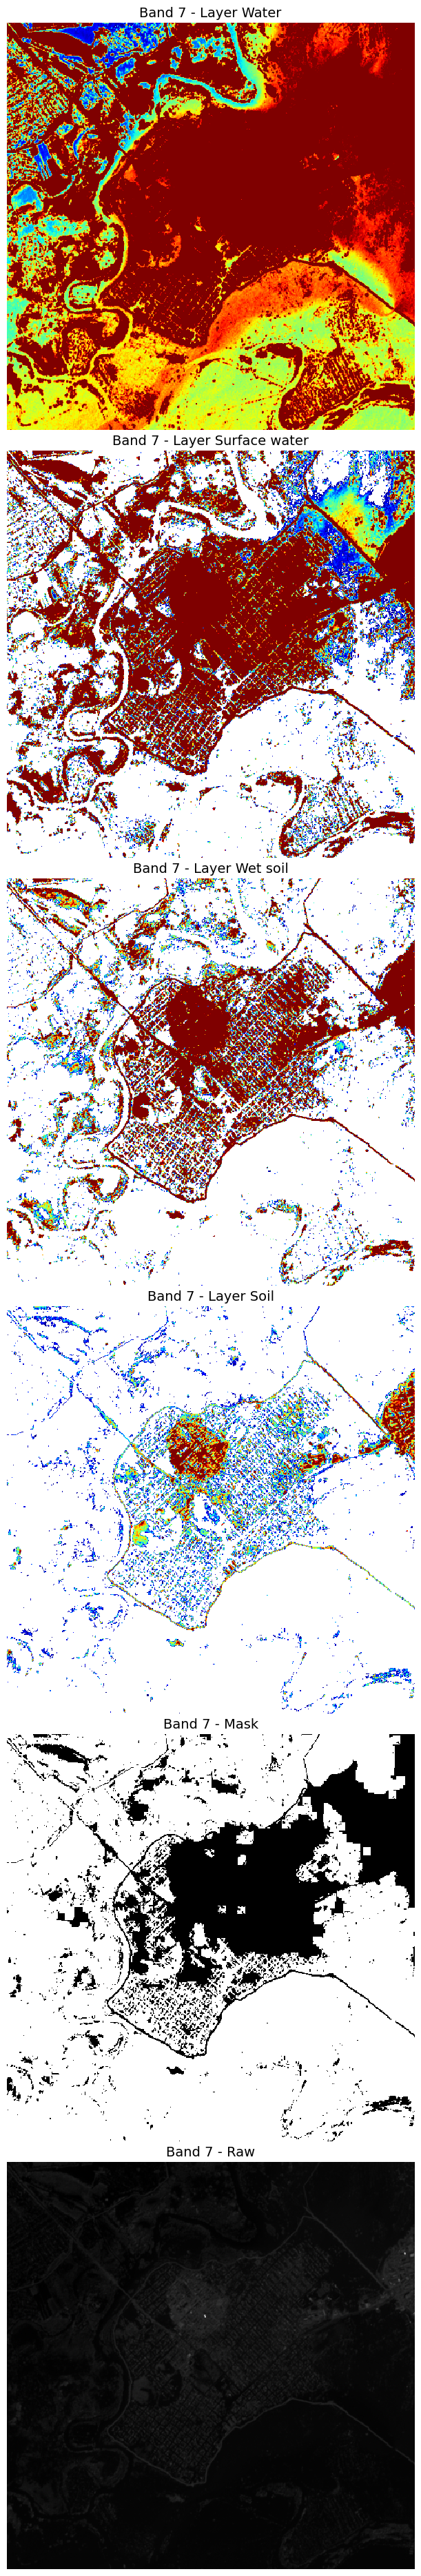

In [917]:
plot_data_band_display_by_index(images[6], BAND, AS_BITMASK, MASKED, 1)

# Visualization of used bands + its division

In [923]:
def plot_data_band_display(image: MultibandImage, binary: bool, masked: bool):
    num_bands = len(image.bands)
    num_layers = 4
    
    plt.figure(figsize=(8 * num_bands, 8 * num_layers))

    for i, band in enumerate(image.bands):
        layers = band.get_all_layers(binary)

        for j, (name, layer) in enumerate(layers.items()):
            img = band.get_normalized_layer(layer, masked)
            
            plt.subplot(num_layers, num_bands, j * num_bands + i + 1)
            plt.imshow(img, cmap='grey' if binary else 'jet', interpolation='nearest')
            plt.title(f'Band {band.band_index} - Layer {name}', fontsize=14)
            plt.axis('off')

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

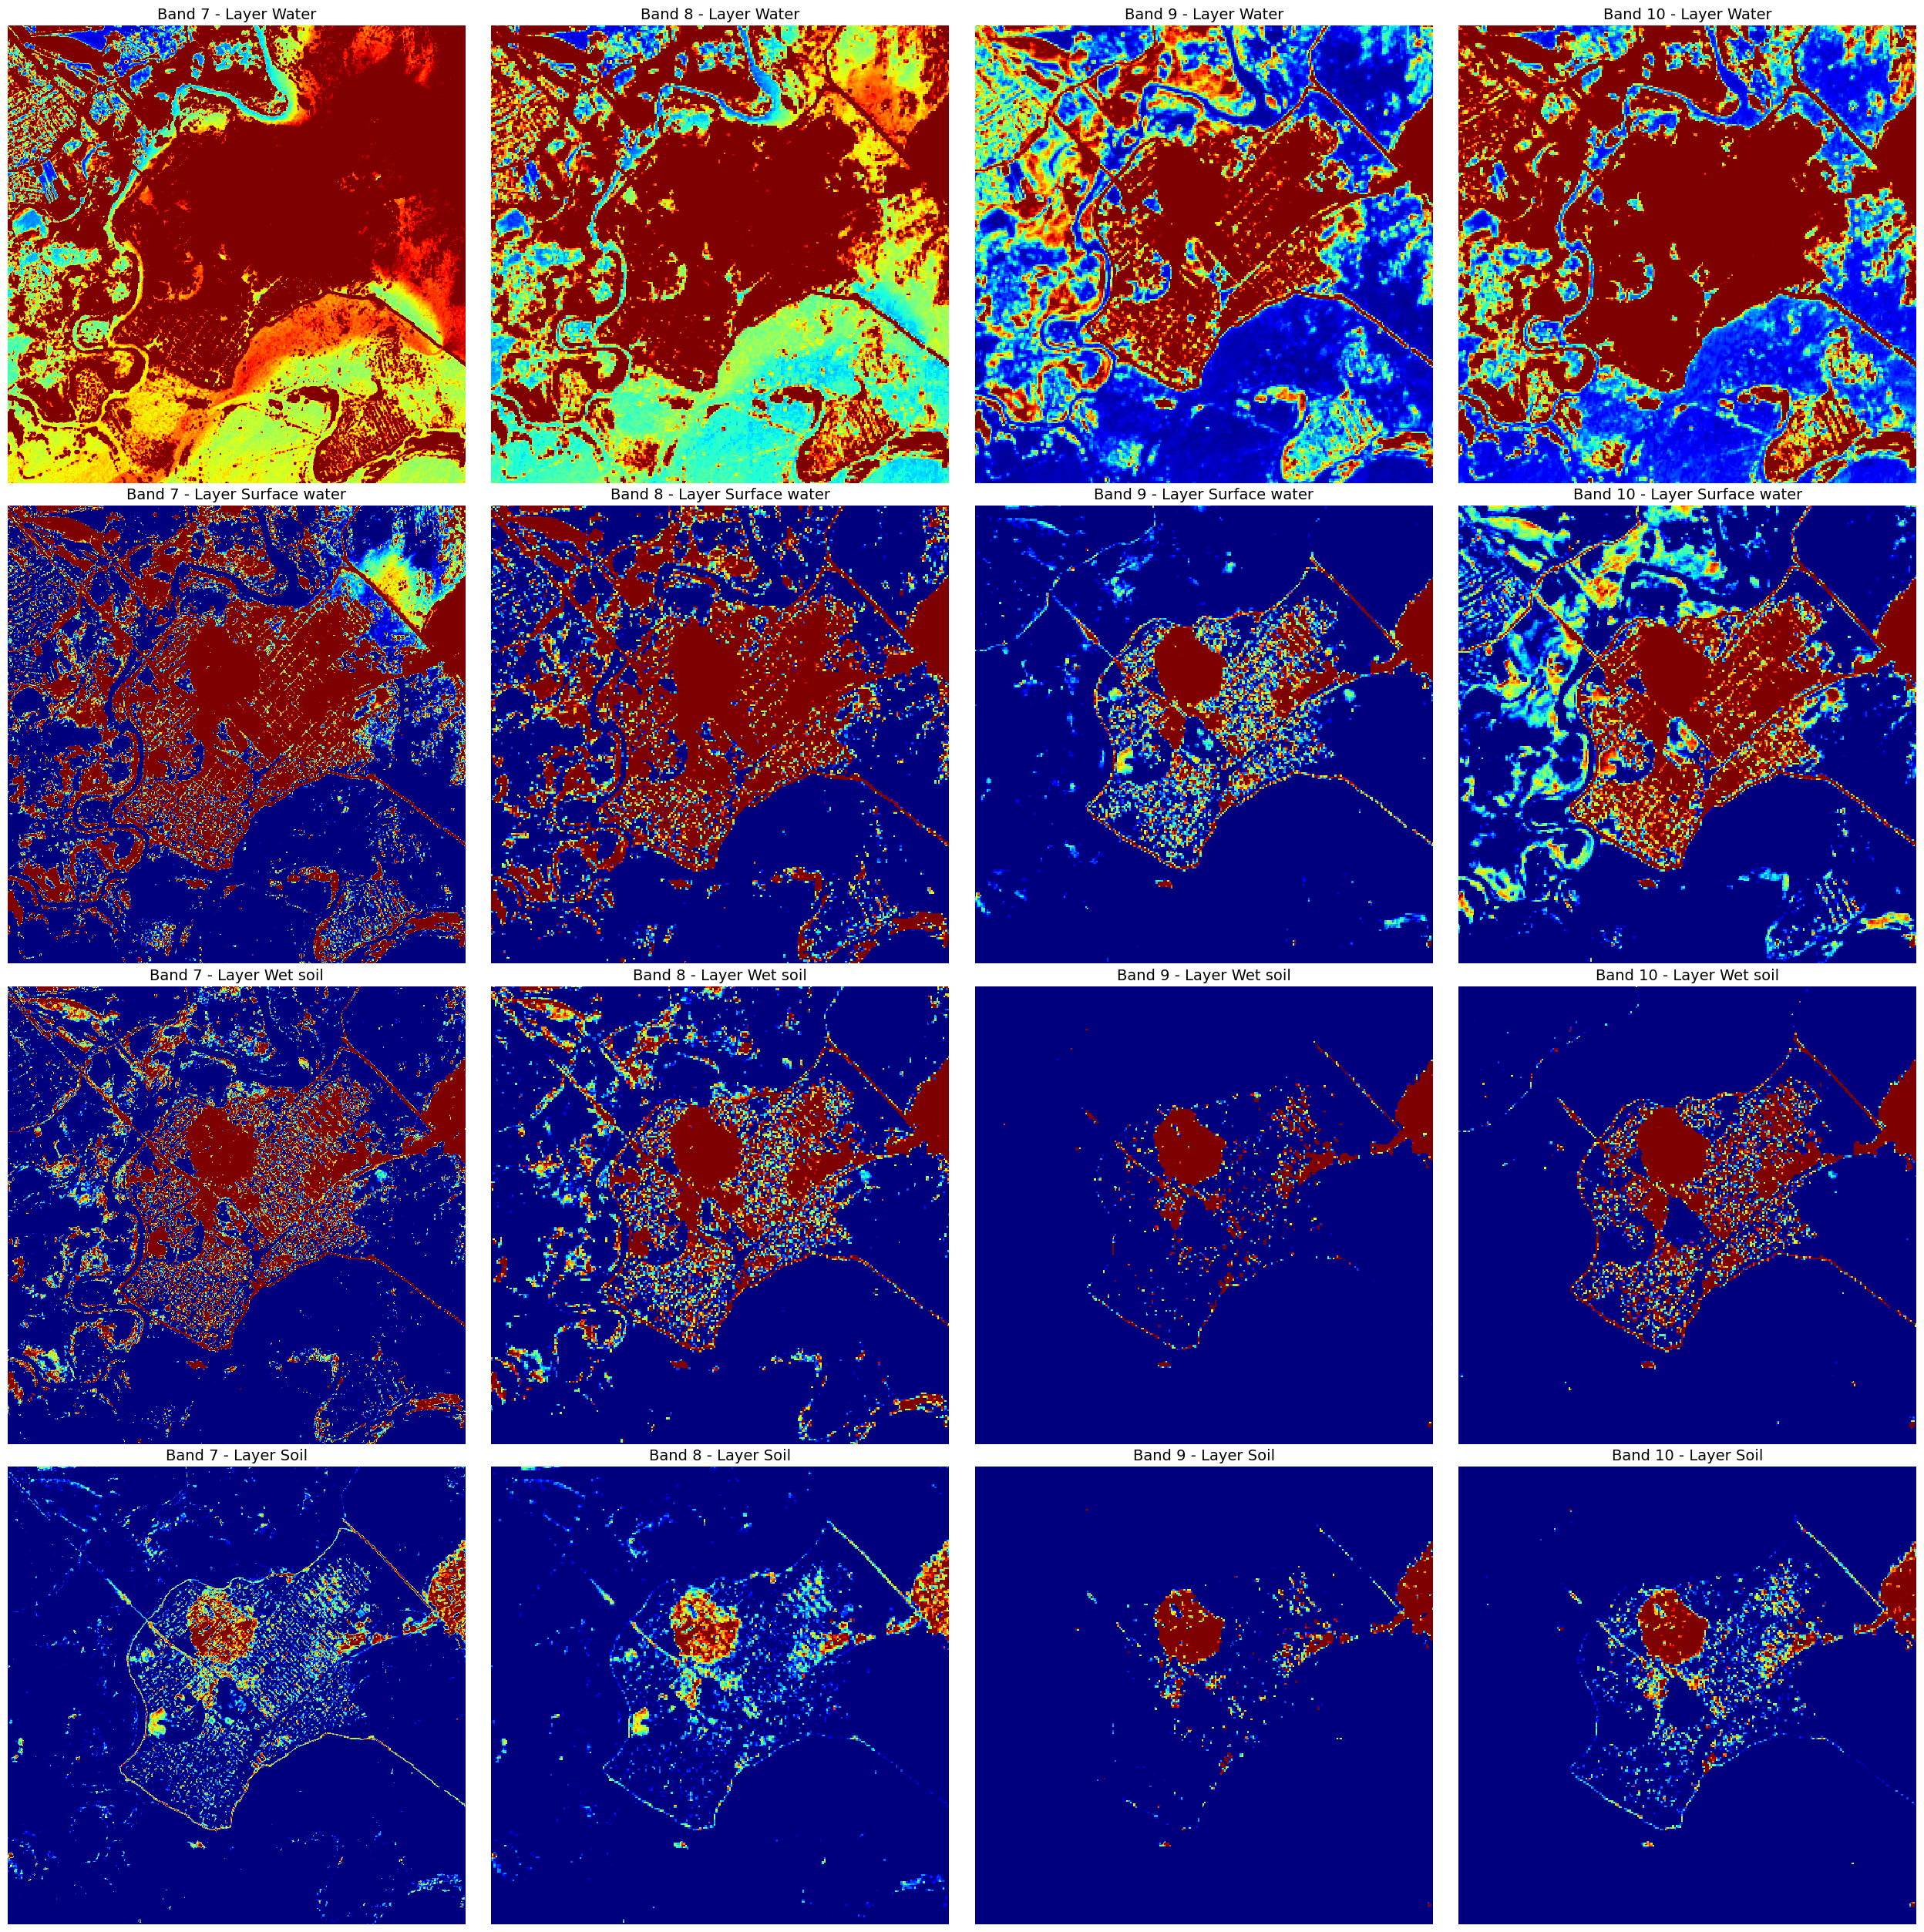

In [869]:
# for image in images:
#     plot_data_band_display(image, False, False)
plot_data_band_display(images[6], False, False)

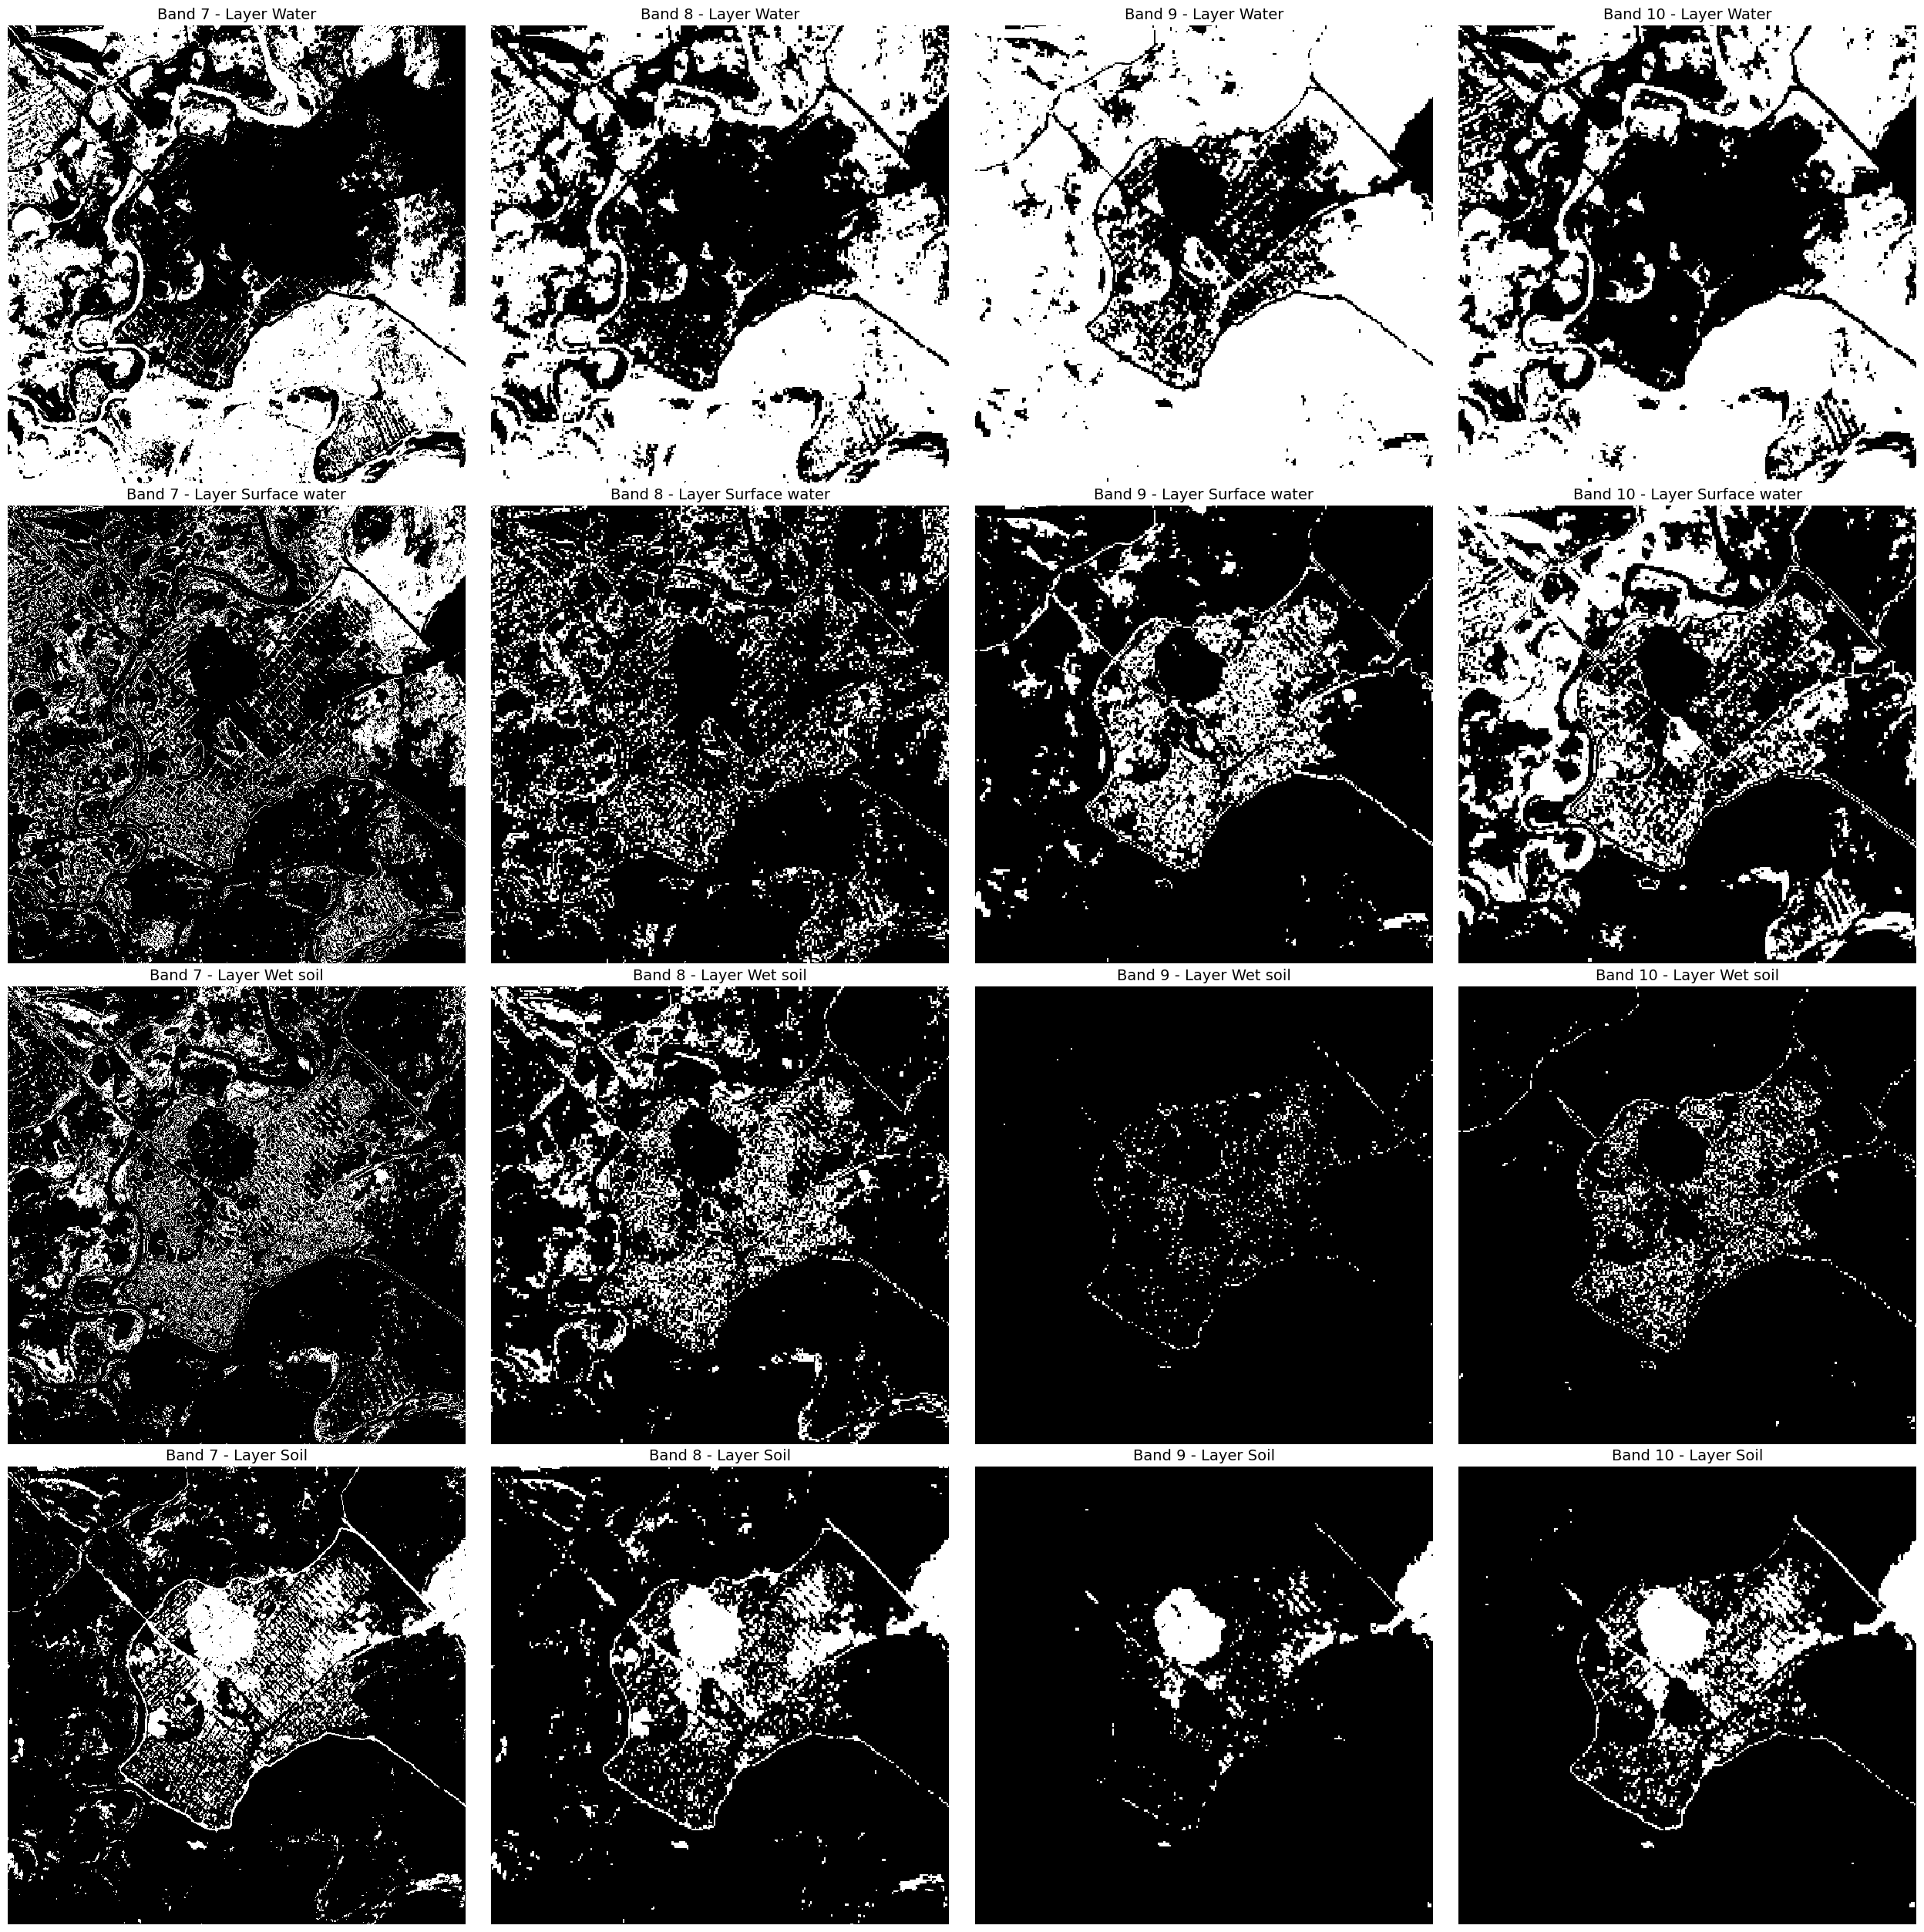

In [924]:
# for image in images:
#     plot_data_band_display(image, False, False)
plot_data_band_display(images[6], True, False)

### Example mask

In [1023]:
def plot_data(image: MultibandImage):
    plt.figure(figsize=(12, 12))

    plt.subplot(1, 2, 1)
    img = image.get_band(7).band_data_clamped
    plt.imshow(img)
    
    plt.imshow(img, cmap='gray', interpolation='nearest')

    plt.subplot(1, 2, 2)
    mask = image.get_water_mask(1, True)
    plt.imshow(mask, cmap='gray', interpolation='nearest')
    plt.show()

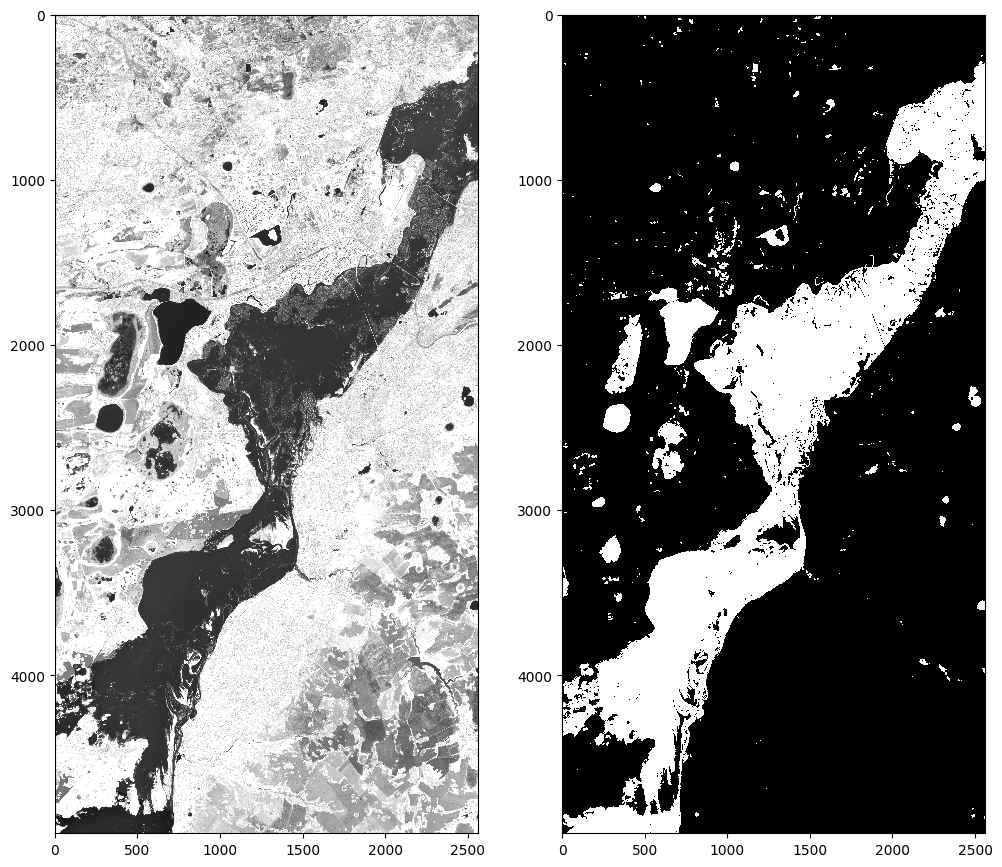

In [1024]:
plot_data(images[1])

# Saving results

In [933]:
def save_mask(image: MultibandImage, sensitivity: float):
    # Here is example of how to save result to geoTiff
    with rasterio.open(image.image_path) as multi_band_src:
        meta = multi_band_src.meta
    
    predict = image.get_water_mask(sensitivity, True)
    meta['count'] = 1
    
    output_folder = os.path.curdir + "/result/"
    os.makedirs(output_folder, exist_ok=True)
    
    name = os.path.basename(image.image_path).replace('.tif', '')
    
    output_filename = os.path.join(output_folder, f"{name}_mask.tif")
    
    with rasterio.open(output_filename, 'w', **meta) as fout:
        fout.write(predict, 1)

In [1005]:
for image in images:
    save_mask(image, 1)